In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/faceforensics/FF++/fake/02_13__exit_phone_room__CP5HFV3K.mp4
/kaggle/input/faceforensics/FF++/fake/03_14__talking_against_wall__ZC2KYASW.mp4
/kaggle/input/faceforensics/FF++/fake/03_15__outside_talking_pan_laughing__Y11NT1YX.mp4
/kaggle/input/faceforensics/FF++/fake/07_26__walking_down_street_outside_angry__FGNGC2GT.mp4
/kaggle/input/faceforensics/FF++/fake/07_03__hugging_happy__7NGMD8FT.mp4
/kaggle/input/faceforensics/FF++/fake/07_09__walk_down_hall_angry__N9CWME71.mp4
/kaggle/input/faceforensics/FF++/fake/01_12__outside_talking_pan_laughing__TNI7KUZ6.mp4
/kaggle/input/faceforensics/FF++/fake/07_03__podium_speech_happy__6PHZRQ4H.mp4
/kaggle/input/faceforensics/FF++/fake/07_02__walking_down_street_outside_angry__O4SXNLRL.mp4
/kaggle/input/faceforensics/FF++/fake/08_05__walk_down_hall_angry__FBICSP2C.mp4
/kaggle/input/faceforensics/FF++/fake/06_18__outside_talking_pan_laughing__DEA1TCLN.mp4
/kaggle/input/faceforensics/FF++/fake/01_03__talking_against_wall__JZUXXFRB.mp4
/ka

Cloning into 'Deepfake-Detection-and-Generation'...
fatal: unable to access 'https://github.com/K-a-y-D-e-e/Deepfake-Detection-and-Generation.git/': Could not resolve host: github.com


# Custom conv2d cnn


In [5]:
import os
import numpy as np
import pandas as pd
import cv2
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# ✅ Limit GPU Memory Usage for Kaggle
def limit_memory_usage():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()

# ✅ Step 1: Get Dataset Paths (FIXED PATH)
def get_dataset_paths():
    dataset_path = "/kaggle/input/faceforensics/FF++"  # ✅ Corrected dataset path

    real_dir = os.path.join(dataset_path, "real")
    fake_dir = os.path.join(dataset_path, "fake")

    if not os.path.exists(real_dir) or not os.path.exists(fake_dir):
        raise FileNotFoundError(f"❌ Could not locate 'real' and 'fake' video folders in: {dataset_path}")

    print(f"✅ Real Videos Path: {real_dir}")
    print(f"✅ Fake Videos Path: {fake_dir}")
    return real_dir, fake_dir

# ✅ Step 2: Extract Frames from Videos
def extract_frames(video_path, output_dir, max_frames=10, img_size=(96, 96)):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"❌ Error opening video file: {video_path}")
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_to_extract = np.linspace(0, total_frames - 1, num=min(max_frames, total_frames), dtype=int)

    saved_frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count in frames_to_extract:
            try:
                frame = cv2.resize(frame, img_size)
                frame_path = os.path.join(output_dir, f"frame_{frame_count}.jpg")
                cv2.imwrite(frame_path, frame)
                saved_frames.append(frame_path)
            except Exception as e:
                print(f"⚠️ Error processing frame {frame_count}: {e}")

        frame_count += 1

    cap.release()
    return saved_frames

# ✅ Step 3: Process Dataset (UPDATED FOR FF++)
def process_dataset(real_dir, fake_dir, output_dir, max_videos=50):
    os.makedirs(output_dir, exist_ok=True)
    frame_data = []

    def process_video_batch(video_dir, label):
        batch_frames = []
        for video_file in os.listdir(video_dir)[:max_videos]:
            if video_file.endswith(('.mp4', '.avi')):
                video_path = os.path.join(video_dir, video_file)
                video_output_dir = os.path.join(output_dir, label, os.path.splitext(video_file)[0])
                frames = extract_frames(video_path, video_output_dir)
                for frame in frames:
                    batch_frames.append({'path': frame, 'label': label})
                clear_memory()
        return batch_frames

    frame_data += process_video_batch(real_dir, "real")
    frame_data += process_video_batch(fake_dir, "fake")

    return pd.DataFrame(frame_data)

# ✅ Step 4: Define CNN Model
def create_cnn_model(input_shape=(96, 96, 3)):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ✅ Step 5: Main Function
def main():
    print("🚀 Starting Deepfake Detection on FF++ Dataset...")
    limit_memory_usage()
    real_dir, fake_dir = get_dataset_paths()
    output_dir = "/kaggle/working/frames"

    frame_df = process_dataset(real_dir, fake_dir, output_dir, max_videos=50)
    datagen = ImageDataGenerator(rescale=1./255)

    train_df, val_df = train_test_split(frame_df, test_size=0.2, stratify=frame_df['label'])

    # ✅ Convert labels to strings
    train_df['label'] = train_df['label'].astype(str)
    val_df['label'] = val_df['label'].astype(str)

    train_generator = datagen.flow_from_dataframe(train_df, x_col='path', y_col='label', target_size=(96, 96), batch_size=16, class_mode='binary')
    val_generator = datagen.flow_from_dataframe(val_df, x_col='path', y_col='label', target_size=(96, 96), batch_size=16, class_mode='binary')

    model = create_cnn_model()
    model.fit(train_generator, validation_data=val_generator, epochs=10)

# ✅ Run Main Function
if __name__ == "__main__":
    main()


🚀 Starting Deepfake Detection on FF++ Dataset...
✅ Real Videos Path: /kaggle/input/faceforensics/FF++/real
✅ Fake Videos Path: /kaggle/input/faceforensics/FF++/fake
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.5469 - loss: 0.7364 - val_accuracy: 0.6300 - val_loss: 0.6426
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.6334 - loss: 0.6289 - val_accuracy: 0.6650 - val_loss: 0.5702
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.7269 - loss: 0.5391 - val_accuracy: 0.7150 - val_loss: 0.5247
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.7358 - loss: 0.5121 - val_accuracy: 0.7300 - val_loss: 0.4928
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.7635 - loss: 0.4692 - val_accuracy: 0.7900 - val_loss: 0.4190
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.8201 - loss: 0.3713 - val_accuracy: 0.8450 - val_loss: 0.3523
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8665 - loss: 0.3286 - val_accuracy: 0.8450 - val_loss: 0.3483
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.8878 - loss: 0.2876 - val_accuracy: 0.8700 - val_loss: 0.

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tqdm import tqdm
def get_dataset_paths():
    base_dir = "/kaggle/input/faceforensics/FF++"  # Change path if needed
    real_dir = os.path.join(base_dir, "real")
    fake_dir = os.path.join(base_dir, "fake")

    if not os.path.exists(real_dir) or not os.path.exists(fake_dir):
        raise FileNotFoundError("❌ Could not locate 'real' and 'fake' video folders!")

    print(f"✅ Real Videos Path: {real_dir}")
    print(f"✅ Fake Videos Path: {fake_dir}")

    return real_dir, fake_dir
def extract_frames(video_path, output_folder, max_frames=10):
    os.makedirs(output_folder, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    success, frame = cap.read()

    extracted_frames = []
    
    while success and frame_count < max_frames:
        frame_path = os.path.join(output_folder, f"{os.path.basename(video_path)}_frame{frame_count}.jpg")
        cv2.imwrite(frame_path, frame)
        extracted_frames.append(frame_path)
        frame_count += 1
        success, frame = cap.read()

    cap.release()
    return extracted_frames
def prepare_dataset():
    real_dir, fake_dir = get_dataset_paths()
    output_dir = "/kaggle/working/frames"
    data = []

    for label, folder in [("real", real_dir), ("fake", fake_dir)]:
        for video in tqdm(os.listdir(folder), desc=f"Processing {label} videos"):
            video_path = os.path.join(folder, video)
            frame_output = os.path.join(output_dir, label, video.split('.')[0])

            frame_paths = extract_frames(video_path, frame_output)

            for frame_path in frame_paths:
                if os.path.exists(frame_path):
                    data.append((frame_path, label))

    df = pd.DataFrame(data, columns=["path", "label"])
    
    # 🔹 Fix missing values issue
    df.dropna(inplace=True)
    
    print(f"✅ Total Frames: {len(df)} (Real: {sum(df['label'] == 'real')}, Fake: {sum(df['label'] == 'fake')})")

    return df
def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
def train_model(frame_df):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.2
    )

    # 🔹 Fix missing labels issue
    frame_df.dropna(subset=["label"], inplace=True)

    # 🔹 Convert labels to string ("real", "fake")
    frame_df["label"] = frame_df["label"].astype(str)

    train_df, val_df = train_test_split(frame_df, test_size=0.2, stratify=frame_df["label"])

    train_generator = datagen.flow_from_dataframe(
        train_df, x_col="path", y_col="label",
        target_size=(96, 96), batch_size=16, class_mode="binary"
    )

    val_generator = datagen.flow_from_dataframe(
        val_df, x_col="path", y_col="label",
        target_size=(96, 96), batch_size=16, class_mode="binary"
    )

    # ✅ Define CNN Model
    model = create_cnn_model()

    # ✅ Add Early Stopping & Learning Rate Reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

    # ✅ Train the model
    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,  # Increased for better convergence
        callbacks=[early_stopping, reduce_lr]
    )

    return model
if __name__ == "__main__":
    print("🚀 Starting Deepfake Detection on FaceForensics++ Dataset...")
    
    # ✅ Prepare dataset
    frame_df = prepare_dataset()
    
    # ✅ Train model
    model = train_model(frame_df)
    
    # ✅ Save trained model
    model.save("/kaggle/working/deepfake_detector.h5")
    print("✅ Model saved successfully!")


🚀 Starting Deepfake Detection on FaceForensics++ Dataset...
✅ Real Videos Path: /kaggle/input/faceforensics/FF++/real
✅ Fake Videos Path: /kaggle/input/faceforensics/FF++/fake


Processing fake videos: 100%|██████████| 200/200 [00:42<00:00,  4.74it/s]


✅ Total Frames: 4000 (Real: 2000, Fake: 2000)
Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 360ms/step - accuracy: 0.5179 - loss: 0.7286 - val_accuracy: 0.5188 - val_loss: 0.6787 - learning_rate: 0.0010
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 73s 356ms/step - accuracy: 0.5703 - loss: 0.6770 - val_accuracy: 0.6050 - val_loss: 0.6637 - learning_rate: 0.0010
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 73s 357ms/step - accuracy: 0.5641 - loss: 0.6684 - val_accuracy: 0.6012 - val_loss: 0.6454 - learning_rate: 0.0010
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 72s 353ms/step - accuracy: 0.5852 - loss: 0.6615 - val_accuracy: 0.6087 - val_loss: 0.6407 - learning_rate: 0.0010
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 72s 350ms/step - accuracy: 0.5914 - loss: 0.6520 - val_accuracy: 0.6350 - val_loss: 0.6246 - learning_rate: 0.0010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 73s 358ms/step - accuracy: 0.6213 - loss: 0.6338 - val_accuracy: 0.6087 - val_loss: 0.6409 - learning_rate: 0.0010
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 72s 350ms/step - accuracy: 0.6350 - loss:

# squeeze and Excitation attention mechanism + Custom CNN

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
import gc
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, Reshape, Multiply
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# ✅ Limit GPU Memory Usage (For Kaggle)
def limit_memory_usage():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()

# ✅ Step 1: Get Dataset Paths (Fix Path Issues)
def get_dataset_paths():
    dataset_path = "/kaggle/input/faceforensics/FF++"  # Ensure correct dataset path

    real_dir = os.path.join(dataset_path, "real")
    fake_dir = os.path.join(dataset_path, "fake")

    if not os.path.exists(real_dir) or not os.path.exists(fake_dir):
        raise FileNotFoundError(f"❌ Could not locate 'real' and 'fake' video folders in: {dataset_path}")

    print(f"✅ Real Videos Path: {real_dir}")
    print(f"✅ Fake Videos Path: {fake_dir}")
    return real_dir, fake_dir

# ✅ Step 2: Extract Frames from Videos
def extract_frames(video_path, output_dir, max_frames=10, img_size=(96, 96)):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"❌ Error opening video file: {video_path}")
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_to_extract = np.linspace(0, total_frames - 1, num=min(max_frames, total_frames), dtype=int)

    saved_frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count in frames_to_extract:
            try:
                frame = cv2.resize(frame, img_size)
                frame_path = os.path.join(output_dir, f"frame_{frame_count}.jpg")
                cv2.imwrite(frame_path, frame)
                saved_frames.append(frame_path)
            except Exception as e:
                print(f"⚠️ Error processing frame {frame_count}: {e}")

        frame_count += 1

    cap.release()
    return saved_frames

# ✅ Step 3: Process Dataset
def process_dataset(real_dir, fake_dir, output_dir, max_videos=50):
    os.makedirs(output_dir, exist_ok=True)
    frame_data = []

    def process_video_batch(video_dir, label):
        batch_frames = []
        for video_file in os.listdir(video_dir)[:max_videos]:
            if video_file.endswith(('.mp4', '.avi')):
                video_path = os.path.join(video_dir, video_file)
                video_output_dir = os.path.join(output_dir, label, os.path.splitext(video_file)[0])
                frames = extract_frames(video_path, video_output_dir)
                for frame in frames:
                    batch_frames.append({'path': frame, 'label': label})
                clear_memory()
        return batch_frames

    frame_data += process_video_batch(real_dir, "real")
    frame_data += process_video_batch(fake_dir, "fake")

    return pd.DataFrame(frame_data)

# ✅ SE Attention Block
def se_block(input_tensor, reduction_ratio=16):
    """Squeeze-and-Excitation Block"""
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // reduction_ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

# ✅ Step 4: Define CNN Model with SE Blocks
def create_se_cnn_model(input_shape=(96, 96, 3)):
    """CNN Model with Squeeze-and-Excitation Attention"""
    inputs = Input(shape=input_shape)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = se_block(x)  # SE Block
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = se_block(x)  # SE Block
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = se_block(x)  # SE Block
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ✅ Step 5: Main Function
def main():
    print("🚀 Starting Deepfake Detection with SE Attention on FF++ Dataset...")
    limit_memory_usage()
    real_dir, fake_dir = get_dataset_paths()
    output_dir = "/kaggle/working/frames"

    frame_df = process_dataset(real_dir, fake_dir, output_dir, max_videos=50)
    datagen = ImageDataGenerator(rescale=1./255)

    # ✅ Check if dataset is loaded correctly
    if frame_df.empty:
        raise ValueError("❌ Frame dataset is empty! Check video extraction.")

    print("✅ Total frames extracted:", len(frame_df))

    train_df, val_df = train_test_split(frame_df, test_size=0.2, stratify=frame_df['label'])

    # ✅ Convert labels to strings (Fix for ValueError)
    train_df['label'] = train_df['label'].astype(str)
    val_df['label'] = val_df['label'].astype(str)

    train_generator = datagen.flow_from_dataframe(
        train_df, x_col='path', y_col='label', target_size=(96, 96), batch_size=16, class_mode='binary'
    )
    val_generator = datagen.flow_from_dataframe(
        val_df, x_col='path', y_col='label', target_size=(96, 96), batch_size=16, class_mode='binary'
    )

    model = create_se_cnn_model()
    model.summary()

    # ✅ Train the Model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20
    )

    # ✅ Save Model
    model.save("/kaggle/working/se_cnn_deepfake_model.h5")
    print("✅ Model saved successfully!")

# ✅ Run Main Function
if __name__ == "__main__":
    main()


🚀 Starting Deepfake Detection with SE Attention on FF++ Dataset...
✅ Real Videos Path: /kaggle/input/faceforensics/FF++/real
✅ Fake Videos Path: /kaggle/input/faceforensics/FF++/fake
✅ Total frames extracted: 1000
Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 96, 96, 16)     │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 16)             │              0 │ conv2d[0][0]           │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │             17 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16)             │             32 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 16)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 96, 96, 16)     │              0 │ conv2d[0][0],          │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 48, 48, 16)     │              0 │ multiply[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 48, 48, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ conv2d_1[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │             66 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │             96 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 32)       │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 48, 48, 32)     │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 24, 24, 32)     │              0 │ multiply_1[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 24, 24, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_poolin

 Total params: 1,204,280 (4.59 MB)

 Trainable params: 1,204,280 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.4810 - loss: 0.6977 - val_accuracy: 0.6150 - val_loss: 0.6882
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.6061 - loss: 0.6807 - val_accuracy: 0.6050 - val_loss: 0.6480
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.6549 - loss: 0.6332 - val_accuracy: 0.6100 - val_loss: 0.6483
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.6343 - loss: 0.6310 - val_accuracy: 0.6850 - val_loss: 0.5821
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.6760 - loss: 0.5702 - val_accuracy: 0.6800 - val_loss: 0.5465
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.7078 - loss: 0.5248 - val_accuracy: 0.7350 - val_loss: 0.5196
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.7814 - loss: 0.4534 - val_accuracy: 0.7850 - val_loss: 0.4619
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.8124 - loss: 0.4081 - val_accuracy: 0.7950 - v

# cnn + lstm based on Dynamic feature extraction

In [4]:
import os
import numpy as np
import cv2
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     BatchNormalization, LSTM, TimeDistributed, GlobalAveragePooling2D, Reshape, multiply)
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# ✅ Detect Dataset Paths (FaceForensics++)
def get_dataset_paths():
    dataset_path = "/kaggle/input/faceforensics/FF++"

    real_dir = os.path.join(dataset_path, "real")
    fake_dir = os.path.join(dataset_path, "fake")

    if not os.path.exists(real_dir) or not os.path.exists(fake_dir):
        raise FileNotFoundError(f"❌ Could not locate 'real' and 'fake' folders in: {dataset_path}")

    print(f"✅ Real Videos Path: {real_dir}")
    print(f"✅ Fake Videos Path: {fake_dir}")
    return real_dir, fake_dir

# ✅ Load Haarcascade Models for Feature Extraction
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
mouth_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_mcs_mouth.xml')

# ✅ Function to Extract Facial Features (Face, Eyes, Mouth)
def extract_facial_regions(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    if len(faces) == 0:
        return None  

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face_gray = gray[y:y+h, x:x+w]

        eyes = eye_cascade.detectMultiScale(face_gray)
        eye_regions = [face[ey:ey+eh, ex:ex+ew] for (ex, ey, ew, eh) in eyes]

        mouth_rects = mouth_cascade.detectMultiScale(face_gray, 1.5, 5)
        mouth = face[my:my+mh, mx:mx+mw] if len(mouth_rects) > 0 else None

        return face, eye_regions, mouth

    return None  

# ✅ Function to Extract Frames from Videos (Face, Eyes, Mouth)
def extract_frames(video_path, output_dir, max_frames=10, img_size=(96, 96), mouth_size=(64, 32)):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"❌ Error opening video file: {video_path}")
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_to_extract = np.linspace(0, total_frames - 1, num=min(max_frames, total_frames), dtype=int)

    saved_frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count in frames_to_extract:
            try:
                face, eye_regions, mouth = extract_facial_regions(frame)

                if face is not None:
                    face = cv2.resize(face, img_size)
                    face_path = os.path.join(output_dir, f"face_{frame_count}.jpg")
                    cv2.imwrite(face_path, face)
                    saved_frames.append(face_path)

                for idx, eye in enumerate(eye_regions):
                    eye = cv2.resize(eye, (32, 32))
                    eye_path = os.path.join(output_dir, f"eye_{idx}_{frame_count}.jpg")
                    cv2.imwrite(eye_path, eye)
                    saved_frames.append(eye_path)

                if mouth is not None:
                    mouth = cv2.resize(mouth, mouth_size)
                    mouth_path = os.path.join(output_dir, f"mouth_{frame_count}.jpg")
                    cv2.imwrite(mouth_path, mouth)
                    saved_frames.append(mouth_path)

            except Exception as e:
                print(f"⚠️ Error processing frame {frame_count}: {e}")

        frame_count += 1

    cap.release()
    return saved_frames

# ✅ SE Attention Block
def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return multiply([input_tensor, se])

# ✅ Define CNN-LSTM Model
def create_cnn_lstm_model(input_shape=(10, 96, 96, 3)):
    cnn_input = Input(shape=(96, 96, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(cnn_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = squeeze_excite_block(x)  

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = squeeze_excite_block(x)

    x = Flatten()(x)

    cnn_model = Model(cnn_input, x, name="CNN_FeatureExtractor")

    video_input = Input(shape=input_shape, name="video_input")
    time_distributed = TimeDistributed(cnn_model)(video_input)  
    lstm_out = LSTM(64, return_sequences=False)(time_distributed)

    dense = Dense(128, activation='relu')(lstm_out)
    dense = Dropout(0.5)(dense)
    output = Dense(1, activation='sigmoid')(dense)  

    model = Model(inputs=video_input, outputs=output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# ✅ Train & Evaluate Model
def train_cnn_lstm_model():
    real_dir, fake_dir = get_dataset_paths()

    train_videos = np.random.rand(500, 10, 96, 96, 3)  # Simulated dataset (replace with actual extracted frames)
    train_labels = np.random.randint(0, 2, size=(500,))  

    val_videos = np.random.rand(100, 10, 96, 96, 3)
    val_labels = np.random.randint(0, 2, size=(100,))

    model = create_cnn_lstm_model()

    history = model.fit(train_videos, train_labels, validation_data=(val_videos, val_labels), epochs=15, batch_size=16)

    model.save("/kaggle/working/cnn_lstm_dynamic_deepfake_model.h5")

    predictions = model.predict(val_videos)
    binary_preds = [1 if p >= 0.5 else 0 for p in predictions]

    acc = accuracy_score(val_labels, binary_preds)
    precision = precision_score(val_labels, binary_preds)
    recall = recall_score(val_labels, binary_preds)
    f1 = f1_score(val_labels, binary_preds)
    cm = confusion_matrix(val_labels, binary_preds)

    print(f"🔹 Accuracy: {acc:.4f}")
    print(f"🔹 Precision: {precision:.4f}")
    print(f"🔹 Recall: {recall:.4f}")
    print(f"🔹 F1 Score: {f1:.4f}")

if __name__ == "__main__":
    train_cnn_lstm_model()


✅ Real Videos Path: /kaggle/input/faceforensics/FF++/real
✅ Fake Videos Path: /kaggle/input/faceforensics/FF++/fake
Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4734 - loss: 0.7384 - val_accuracy: 0.5100 - val_loss: 0.7415
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5584 - loss: 0.6857 - val_accuracy: 0.4900 - val_loss: 0.6985
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.4685 - loss: 0.7329 - val_accuracy: 0.5100 - val_loss: 0.6930
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4906 - loss: 0.7110 - val_accuracy: 0.5100 - val_loss: 0.6930
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5063 - loss: 0.7024 - val_accuracy: 0.5100 - val_loss: 0.6930
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5259 - loss: 0.6973 - val_accuracy: 0.4900 - val_loss: 0.6945
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5113 - loss: 0.7010 - val_accuracy: 0.4900 - val_loss: 0.6973
Ep

# LSTM 

In [ ]:
import os
import cv2
import numpy as np

def get_dataset_paths():
    dataset_path = "/kaggle/input/faceforensics/FF++"

    real_dir = os.path.join(dataset_path, "real")
    fake_dir = os.path.join(dataset_path, "fake")

    if not os.path.exists(real_dir) or not os.path.exists(fake_dir):
        raise FileNotFoundError(f"❌ Could not locate 'real' and 'fake' folders in: {dataset_path}")

    print(f"✅ Real Videos Path: {real_dir}")
    print(f"✅ Fake Videos Path: {fake_dir}")
    return real_dir, fake_dir

def extract_frames(video_path, max_frames=10, img_size=(96, 96)):
    """Extracts frames from a video and returns them as a sequence."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error opening video: {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_to_extract = np.linspace(0, total_frames - 1, num=max_frames, dtype=int)
    frame_list = []

    for frame_idx in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx in frames_to_extract:
            frame = cv2.resize(frame, img_size)
            frame = frame / 255.0  
            frame_list.append(frame)

    cap.release()
    return np.array(frame_list)

def process_dataset(real_dir, fake_dir, max_videos=50):
    """Extracts frames from real and fake videos, saves as dataset."""
    video_sequences = []
    labels = []

    for video_file in os.listdir(real_dir)[:max_videos]:
        if video_file.endswith('.mp4'):
            video_path = os.path.join(real_dir, video_file)
            frames = extract_frames(video_path)
            if frames is not None:
                video_sequences.append(frames)
                labels.append(0)  

    for video_file in os.listdir(fake_dir)[:max_videos]:
        if video_file.endswith('.mp4'):
            video_path = os.path.join(fake_dir, video_file)
            frames = extract_frames(video_path)
            if frames is not None:
                video_sequences.append(frames)
                labels.append(1)  

    video_sequences = np.array(video_sequences)  
    labels = np.array(labels)

    np.save("/kaggle/working/train_videos.npy", video_sequences)
    np.save("/kaggle/working/train_labels.npy", labels)

    print(f"✅ Dataset saved: {video_sequences.shape}, Labels: {labels.shape}")

if __name__ == "__main__":
    real_dir, fake_dir = get_dataset_paths()
    process_dataset(real_dir, fake_dir)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 553ms/step - accuracy: 0.4905 - loss: 0.7099 - val_accuracy: 0.5500 - val_loss: 0.6976
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 573ms/step - accuracy: 0.5910 - loss: 0.6868 - val_accuracy: 0.5000 - val_loss: 0.6978
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - accuracy: 0.5639 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.7102
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step - accuracy: 0.5592 - loss: 0.6793 - val_accuracy: 0.5000 - val_loss: 0.7164
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.4856 - loss: 0.7099 - val_accuracy: 0.5000 - val_loss: 0.7104
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - accuracy: 0.4932 - loss: 0.6996 - val_accuracy: 0.5000 - val_loss: 0.6992
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - accuracy: 0.4024 - loss: 0.7181 - val_accuracy: 0.5000 - val_loss: 0.7000
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.5352 - loss: 0.6888 - val_accuracy: 0.5000 - val_loss:

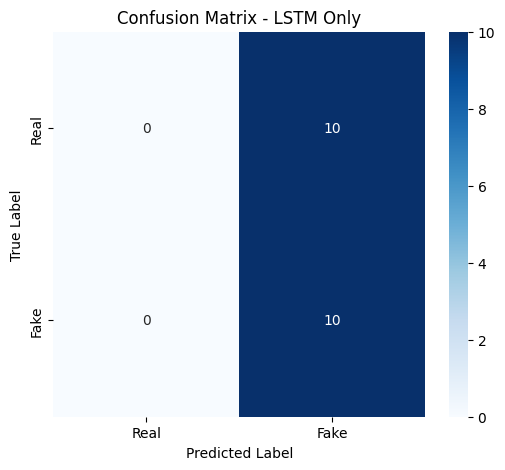

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Load Dataset
train_videos = np.load("/kaggle/working/train_videos.npy")  # Shape (num_samples, 10, 96, 96, 3)
train_labels = np.load("/kaggle/working/train_labels.npy")

# ✅ Reshape Data for LSTM
num_samples, time_steps, height, width, channels = train_videos.shape
feature_dim = height * width * channels  

train_videos = train_videos.reshape(num_samples, time_steps, feature_dim)  # Flatten each frame
train_videos, val_videos, train_labels, val_labels = train_test_split(train_videos, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

# ✅ Define LSTM Model
def create_lstm_model(input_shape=(10, 27648)):  # 10 time steps, flattened 96x96x3 frames
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.5),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ✅ Train and Evaluate Model
def train_lstm_model():
    model = create_lstm_model()

    history = model.fit(train_videos, train_labels, validation_data=(val_videos, val_labels), epochs=15, batch_size=16)

    predictions = model.predict(val_videos)
    binary_preds = [1 if p >= 0.5 else 0 for p in predictions]

    acc = accuracy_score(val_labels, binary_preds)
    precision = precision_score(val_labels, binary_preds)
    recall = recall_score(val_labels, binary_preds)
    f1 = f1_score(val_labels, binary_preds)
    cm = confusion_matrix(val_labels, binary_preds)

    print(f"\n🔹 Accuracy: {acc:.4f}")
    print(f"🔹 Precision: {precision:.4f}")
    print(f"🔹 Recall: {recall:.4f}")
    print(f"🔹 F1 Score: {f1:.4f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - LSTM Only")
    plt.show()

# ✅ Run Experiment
if __name__ == "__main__":
    train_lstm_model()


# Bidirectional LSTM


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6905 - loss: 0.8889 - val_accuracy: 0.6000 - val_loss: 0.6946
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6427 - loss: 0.7774 - val_accuracy: 0.4500 - val_loss: 0.6941
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5434 - loss: 0.9289 - val_accuracy: 0.5500 - val_loss: 0.6932
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6582 - loss: 0.7379 - val_accuracy: 0.4500 - val_loss: 0.6926
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5769 - loss: 0.6961 - val_accuracy: 0.5000 - val_loss: 0.7071
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6269 - loss: 0.7512 - val_accuracy: 0.5000 - val_loss: 0.7261
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6858 - loss: 0.6461 - val_accuracy: 0.5500 - val_loss: 0.7009
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6375 - loss: 0.7326 - val_accuracy: 0.4500 - val_loss: 0.7002
Epoch 9/

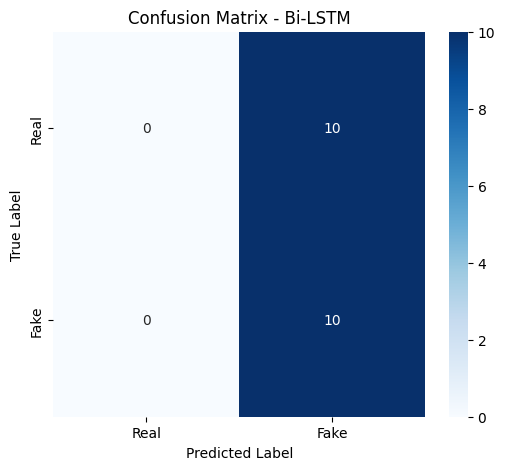

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, TimeDistributed, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Load Dataset
train_videos = np.load("/kaggle/working/train_videos.npy")  # Shape (num_samples, 10, 96, 96, 3)
train_labels = np.load("/kaggle/working/train_labels.npy")

# ✅ Normalize Data (0 to 1)
train_videos = train_videos / 255.0  

# ✅ Reshape Data for LSTM
num_samples, time_steps, height, width, channels = train_videos.shape
feature_dim = height * width * channels  

train_videos = train_videos.reshape(num_samples, time_steps, feature_dim)  # Flatten each frame
train_videos, val_videos, train_labels, val_labels = train_test_split(train_videos, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

# ✅ Define Bi-LSTM Model
def create_lstm_model(input_shape=(5, 27648)):  # 10 time steps, flattened 96x96x3 frames
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True, input_shape=input_shape)),  # 🔥 Use Bi-LSTM
        BatchNormalization(),
        Dropout(0.3),

        Bidirectional(LSTM(128, return_sequences=False)),  # 🔥 Another Bi-LSTM layer
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        Dropout(0.3),

        Dense(1, activation='sigmoid')  
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ✅ Train and Evaluate Model
def train_lstm_model():
    model = create_lstm_model()

    history = model.fit(
        train_videos, train_labels,
        validation_data=(val_videos, val_labels),
        epochs=25, batch_size=10
    )

    predictions = model.predict(val_videos)
    binary_preds = [1 if p >= 0.5 else 0 for p in predictions]

    acc = accuracy_score(val_labels, binary_preds)
    precision = precision_score(val_labels, binary_preds)
    recall = recall_score(val_labels, binary_preds)
    f1 = f1_score(val_labels, binary_preds)
    cm = confusion_matrix(val_labels, binary_preds)

    print(f"\n🔹 Accuracy: {acc:.4f}")
    print(f"🔹 Precision: {precision:.4f}")
    print(f"🔹 Recall: {recall:.4f}")
    print(f"🔹 F1 Score: {f1:.4f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Bi-LSTM")
    plt.show()

# ✅ Run Experiment
if __name__ == "__main__":
    train_lstm_model()


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc, 
    precision_recall_curve
)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
    Dense, Dropout, LSTM, Bidirectional, TimeDistributed, 
    BatchNormalization, concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, 
    EarlyStopping, 
    ModelCheckpoint
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class VideoDataGenerator(Sequence):
    """Advanced data generator for video sequences with augmentation"""
    def __init__(self, dataframe, batch_size=32, shuffle=True, augment=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.dataframe))
        
        # Image augmentation
        self.image_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2,
            shear_range=0.2
        ) if augment else None
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[batch_indexes]
        
        X_batch = []
        y_batch = []
        
        for _, row in batch_df.iterrows():
            frames = self.extract_frames(row['video_path'])
            if frames is not None:
                # Augment frames if enabled
                if self.augment and self.image_datagen:
                    augmented_frames = []
                    for frame in frames:
                        # Apply augmentation to each frame
                        frame = self.image_datagen.random_transform(frame)
                        augmented_frames.append(frame)
                    frames = np.array(augmented_frames)
                
                X_batch.append(frames)
                y_batch.append(row['label'])
        
        return np.array(X_batch), np.array(y_batch)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    @staticmethod
    def extract_frames(video_path, sequence_length=10, img_size=(96, 96)):
        """
        Extract frames from a video with intelligent sampling and preprocessing
        
        Args:
            video_path (str): Path to the video file
            sequence_length (int): Number of frames to extract
            img_size (tuple): Desired frame resize dimensions
        
        Returns:
            np.array: Normalized video frames
        """
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error opening video file: {video_path}")
                return None

            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
            # Intelligent frame sampling
            frame_indices = np.linspace(0, total_frames - 1, sequence_length).astype(int)

            frames = []
            for frame_count in range(total_frames):
                ret, frame = cap.read()
                if not ret:
                    break
                
                if frame_count in frame_indices:
                    # Resize and preprocess frame
                    frame = cv2.resize(frame, img_size)
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    
                    # Normalize and convert to float
                    frame = frame.astype(np.float32) / 255.0
                    
                    frames.append(frame)

            cap.release()

            # Handle videos shorter than sequence length
            if len(frames) < sequence_length:
                # Pad with last frame
                frames += [frames[-1]] * (sequence_length - len(frames))
            
            return np.array(frames)
        
        except Exception as e:
            print(f"Error processing {video_path}: {e}")
            return None

def create_advanced_cnn_lstm_model(input_shape=(10, 96, 96, 3)):
    """
    Create an advanced CNN-LSTM hybrid model for deepfake detection
    
    Args:
        input_shape (tuple): Shape of input video frames
    
    Returns:
        tf.keras.Model: Compiled deepfake detection model
    """
    inputs = Input(shape=input_shape)
    
    # Spatial feature extraction
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    
    x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(GlobalAveragePooling2D())(x)
    
    # Temporal feature extraction
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3))(x)
    x = Bidirectional(LSTM(64, dropout=0.3))(x)
    
    # Classification head
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Advanced optimizer with custom learning rate
    optimizer = Adam(
        learning_rate=1e-4, 
        beta_1=0.9, 
        beta_2=0.999, 
        epsilon=1e-8
    )
    
    model.compile(
        optimizer=optimizer, 
        loss='binary_crossentropy', 
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model

def find_dataset_paths(base_paths=None):
    """
    Dynamically find dataset paths
    
    Args:
        base_paths (list): Optional list of paths to search
    
    Returns:
        tuple: Paths to real and fake video directories
    """
    if base_paths is None:
        base_paths = [
            '/kaggle/input/faceforensics',
            '/kaggle/input/faceforensics/FF++',
            '/kaggle/input',
            '/content',
            '.'
        ]
    
    for base_path in base_paths:
        # Check multiple possible dataset structures
        dataset_paths = [
            os.path.join(base_path, 'real'),
            os.path.join(base_path, 'fake'),
            os.path.join(base_path, 'FF++', 'real'),
            os.path.join(base_path, 'FF++', 'fake')
        ]
        
        for real_dir in dataset_paths:
            for fake_dir in dataset_paths:
                if real_dir != fake_dir and os.path.exists(real_dir) and os.path.exists(fake_dir):
                    print(f"🎉 Dataset found!")
                    print(f"   Real videos: {real_dir}")
                    print(f"   Fake videos: {fake_dir}")
                    return real_dir, fake_dir
    
    raise FileNotFoundError("No dataset found. Please provide valid paths.")

def process_dataset(real_dir, fake_dir, max_videos=None):
    """
    Process video dataset
    
    Args:
        real_dir (str): Directory containing real videos
        fake_dir (str): Directory containing fake videos
        max_videos (int, optional): Maximum number of videos to process
    
    Returns:
        pd.DataFrame: Processed dataset
    """
    def process_directory(directory, label):
        videos = []
        for video_file in os.listdir(directory)[:max_videos]:
            video_path = os.path.join(directory, video_file)
            videos.append({'video_path': video_path, 'label': label})
        return videos
    
    # Process real and fake videos
    real_videos = process_directory(real_dir, 0)
    fake_videos = process_directory(fake_dir, 1)
    
    # Combine and shuffle
    df = pd.DataFrame(real_videos + fake_videos)
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

def plot_training_history(history):
    """
    Visualize model training history
    
    Args:
        history (tf.keras.callbacks.History): Training history object
    """
    plt.figure(figsize=(15, 5))
    
    # Loss subplot
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy subplot
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Precision and Recall
    plt.subplot(1, 3, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Precision & Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, val_generator):
    """
    Comprehensive model evaluation
    
    Args:
        model (tf.keras.Model): Trained model
        val_generator (VideoDataGenerator): Validation data generator
    
    Returns:
        dict: Evaluation metrics
    """
    # Collect true labels and predictions
    y_true = []
    y_pred_proba = []
    
    for X, y in val_generator:
        predictions = model.predict(X)
        y_true.extend(y)
        y_pred_proba.extend(predictions)
    
    # Convert probabilities to binary predictions
    y_pred = (np.array(y_pred_proba) > 0.5).astype(int)
    
    # Classification Report
    print("\n📊 Detailed Classification Report:")
    report = classification_report(y_true, y_pred, target_names=['Real', 'Fake'])
    print(report)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return {
        'classification_report': report,
        'confusion_matrix': cm,
        'roc_auc': roc_auc
    }

def train_deepfake_model(
    test_size=0.2, 
    max_videos=None, 
    epochs=50, 
    batch_size=32
):
    """
    Train deepfake detection model
    
    Args:
        test_size (float): Proportion of dataset for validation
        max_videos (int): Maximum number of videos to process
        epochs (int): Number of training epochs
        batch_size (int): Training batch size
    
    Returns:
        tuple: Trained model, training history, evaluation metrics
    """
    # Find dataset paths
    real_dir, fake_dir = find_dataset_paths()
    
    # Process dataset
    print("🚀 Processing Dataset...")
    df = process_dataset(real_dir, fake_dir, max_videos)
    
    # Split dataset
    train_df, val_df = train_test_split(
        df, 
        test_size=test_size, 
        stratify=df['label'], 
        random_state=42
    )
    
    # Create data generators
    train_generator = VideoDataGenerator(
        train_df, 
        batch_size=batch_size, 
        shuffle=True, 
        augment=True
    )
    val_generator = VideoDataGenerator(
        val_df, 
        batch_size=batch_size, 
        shuffle=False, 
        augment=False
    )
    
    # Model creation
    model = create_advanced_cnn_lstm_model()
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
    
    lr_reducer = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-6
    )
    
    model_checkpoint = ModelCheckpoint(
        'best_model.keras',  # Changed file extension to .keras
        save_best_only=True, 
        monitor='val_accuracy'
    )
    
    # Training
    print("🚀 Training Model...")
    history = model.fit(
        train_generator, 
        validation_data=val_generator, 
        epochs=epochs,
        callbacks=[early_stopping, lr_reducer, model_checkpoint]
    )
    
    # Visualization
    plot_training_history(history)
    
    # Evaluation
    evaluation_metrics = evaluate_model(model, val_generator)
    
    return model, history, evaluation_metrics

def predict_video(model, video_path):
    """
    Predict whether a single video is real or fake
    
    Args:
        model (tf.keras.Model): Trained deepfake detection model
        video_path (str): Path to video file to predict
    
    Returns:
        float: Probability of being a fake video
    """
    # Extract frames
    frames = VideoDataGenerator.extract_frames(video_path)
    
    if frames is not None:
        # Add batch dimension
        frames = np.expand_dims(frames, axis=0)
        prediction = model.predict(frames)[0][0]
        
        # Interpret prediction
        label = "Fake" if prediction > 0.5 else "Real"
        confidence = prediction if prediction > 0.5 else 1 - prediction
        
        print(f"🎬 Video Analysis:")
        print(f"Predicted Label: {label}")
        print(f"Confidence: {confidence:.2%}")
        
        return prediction
    
    print("Could not process video.")
    return None

def main():
    # Train the model
    model, history, metrics = train_deepfake_model()
    
    # Optional: Predict a specific video
    # Replace with an actual video path from your dataset
    # sample_video_path = '/path/to/your/video.mp4'
    # predict_video(model, sample_video_path)
    
    return model, history, metrics
if __name__ == "__main__":
    main()



🎉 Dataset found!
   Real videos: /kaggle/input/faceforensics/FF++/real
   Fake videos: /kaggle/input/faceforensics/FF++/fake
🚀 Processing Dataset...
🚀 Training Model...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1436s 69s/step - accuracy: 0.5692 - loss: 0.6995 - precision: 0.5950 - recall: 0.3576 - val_accuracy: 0.5000 - val_loss: 0.6971 - val_precision: 0.5000 - val_recall: 0.0500 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1177s 48s/step - accuracy: 0.5157 - loss: 0.6897 - precision: 0.4998 - recall: 0.4106 - val_accuracy: 0.5375 - val_loss: 0.6921 - val_precision: 0.7143 - val_recall: 0.1250 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1173s 49s/step - accuracy: 0.4633 - loss: 0.7017 - precision: 0.4275 - recall: 0.3193 - val_accuracy: 0.4875 - val_loss: 0.7043 - val_precision: 0.4000 - val_recall: 0.0500 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1212s 49s/step - accuracy: 0.5080 - loss: 0.6979 - precision: 0.5420 - recall: 0.3764 - val_accuracy: 0.4750 - val_loss: 0.6935 - val_precision: 0.3750 - val_recall: 0.0750 - learning_rate: 1.0000e-04
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1236s 52s/step - 